# Viewing and manipulating FITS images

## Authors
Lia Corrales

## Learning Goals
- TODO

## Keywords
matplotlib, FITS image, table

## Summary

Demonstrates the use of `astropy.utils.data` to download a data file, uses `astropy.io.fits` to open the file, uses `matplotlib` to view the image with different color scales and stretches and to make histrograms. Also includes a demonstration of simple image stacking.

In [21]:
import numpy as np

# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits

The following cell is needed to download the example FITS files used here.

In [22]:
from astropy.utils.data import download_file
image_file = download_file('http://data.astropy.org/tutorials/FITS-images/HorseHead.fits', cache=True )

## Opening FITS files and loading the image data

I will open the FITS file and find out what it contains.

In [23]:
hdu_list = fits.open(image_file)
hdu_list.info()

Filename: C:\Users\daniel3wu\.astropy\cache\download\py3\2c9202ae878ecfcb60878ceb63837f5f
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     161   (891, 893)   int16   
  1  er.mask       1 TableHDU        25   1600R x 4C   [F6.2, F6.2, F6.2, F6.2]   


Generally the image information is located in the <code>PRIMARY</code> block. The blocks are numbered and can be accessed by indexing <code>hdu_list</code>.

In [24]:
image_data = hdu_list[0].data

You data is now stored as a 2-D numpy array.  Want to know the dimensions of the image?  Just look at the `shape` of the array.

In [25]:
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(893, 891)


At this point, we can just close the FITS file.  We have stored everything we wanted to a variable.

In [26]:
hdu_list.close()

### SHORTCUT

If you don't need to examine the FITS header, you can call `fits.getdata` to bypass the previous steps.

In [27]:
image_data = fits.getdata(image_file)
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(893, 891)


## Viewing the image data and getting basic statistics

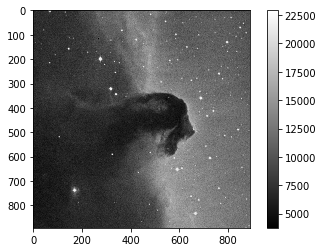

In [28]:
plt.imshow(image_data, cmap='gray')
plt.colorbar()

# To see more color maps
# http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps

Let's get some basic statistics about our image

In [29]:
print('Min:', np.min(image_data))
print('Max:', np.max(image_data))
print('Mean:', np.mean(image_data))
print('Stdev:', np.std(image_data))

Min: 3759
Max: 22918
Mean: 9831.48167629
Stdev: 3032.3927542


### Plotting a histogram

To make a histogram with `matplotlib.pyplot.hist()`, I need to cast the data from a 2-D to array to something one dimensional.

In this case, I am using the ndarray.flatten() to return a 1-D numpy array.

In [30]:
print(type(image_data.flatten()))

<class 'numpy.ndarray'>


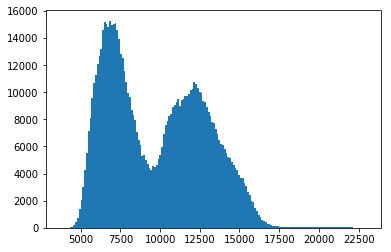

In [31]:
histogram = plt.hist(image_data.flatten(), bins='auto')

### Displaying the image with a logarithmic scale

Want to use a logarithmic color scale? To do so we need to load the `LogNorm` object from `matplotlib`.

In [32]:
from matplotlib.colors import LogNorm

[Text(1,0,'5,000'), Text(1,0,'10,000'), Text(1,0,'20,000')]

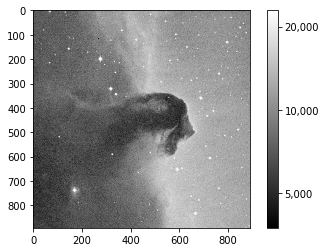

In [33]:
plt.imshow(image_data, cmap='gray', norm=LogNorm())

# I chose the tick marks based on the histogram above
cbar = plt.colorbar(ticks=[5.e3,1.e4,2.e4])
cbar.ax.set_yticklabels(['5,000','10,000','20,000'])

## Basic image math: image stacking

You can perform math with the image data like any other numpy array.  In this particular example, I will stack several images of M13 taken with a ~10'' telescope.

I open a series of FITS files and store the data in a list, which I've named `image_concat`.

In [34]:
base_url = 'http://data.astropy.org/tutorials/FITS-images/M13_blue_{0:04d}.fits'

image_list = [download_file(base_url.format(n), cache=True) 
              for n in range(1, 5+1)]
image_concat = [fits.getdata(image) for image in image_list]

Now I'll stack the images by summing my concatenated list.

In [35]:
# The long way
final_image = np.zeros(shape=image_concat[0].shape)

for image in image_concat:
    final_image += image

# The short way
# final_image = np.sum(image_concat, axis=0)

I'm going to show the image, but I want to decide on the best stretch. To do so I'll plot a histogram of the data.

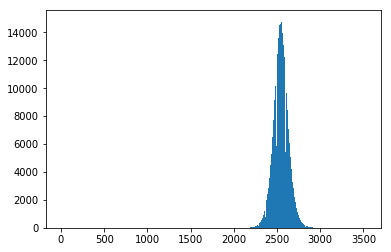

In [36]:
image_hist = plt.hist(final_image.flatten(), bins='auto')

I'll use the keywords `vmin` and `vmax` to set limits on the color scaling for `imshow`.

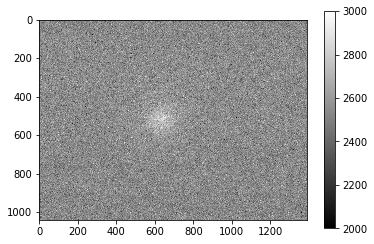

In [37]:
plt.imshow(final_image, cmap='gray', vmin=2E3, vmax=3E3)
plt.colorbar()

## Writing image data to a FITS file

This is easy to do with the `writeto()` method.

You will receive an error if the file you are trying to write already exists.  That's why I've set `overwrite=True`.

In [38]:
outfile = 'stacked_M13_blue.fits'

hdu = fits.PrimaryHDU(final_image)
hdu.writeto(outfile, overwrite=True)

## Exercises

Determine the mean, median, and standard deviation of a part of the stacked M13 image where there is *not* light from M13.  Use those statistics with a sum over the part of the image that includes M13 to estimate the total light in this image from M13.

Show the image of the Horsehead Nebula, but in to units of *surface brightness* (magnitudes per square arcsecond).
(Hint: the *physical* size of the image is 15x15 arcminutes.)

Now write out the image you just created, preserving the header the original image had, but add a keyword 'UNITS' with the value 'mag per sq arcsec'.
(Hint: you may need to read the [astropy.io.fits](http://docs.astropy.org/en/stable/io/fits/index.html) documentation if you're not sure how to include both the header and the data)